## Monthly VAR Model 

Data from 2000-01-31 to 2025-11-30
Total observations: 311

Columns: ['EUR_NOK', 'Q', 'd_pi', 'dI_t', 'Brent', 'VIX', 'StoxEurope', 'SP500', 'OSEBX', 'OBX_Energy']

Training period: 2000-01-31 → 2020-08-31
Test period: 2020-09-30 → 2025-11-30
Out-of-sample observations: 63

Estimating VAR with 2 lags...

=== Model summary ===
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 11, Nov, 2025
Time:                     12:20:37
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -22.9822
Nobs:                     246.000    HQIC:                  -23.1609
Log likelihood:           1837.44    FPE:                7.74507e-11
AIC:                     -23.2814    Det(Omega_mle):     7.11982e-11
--------------------------------------------------------------------
Results for equation Q
             coefficient       std. error           t-stat  

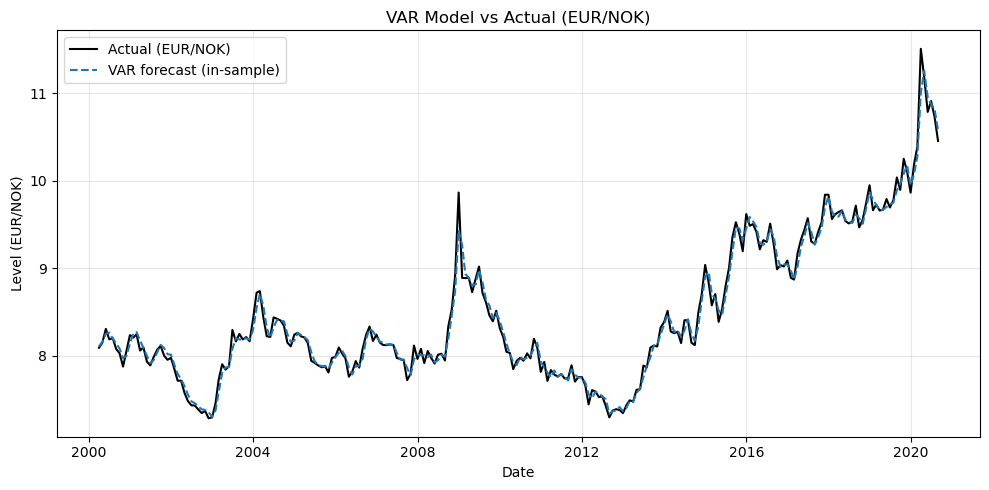

In [19]:
# ==============================================
#   VAR model for EUR/NOK (endogenous variables only)
#   Endogenous: Q, d_pi, dI_t
#   Frequency: monthly (2000–2025)
# ==============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# ----------------------------
# 1) Load dataset
# ----------------------------
df = pd.read_csv("var_monthly.csv")

# Convert and set date index
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
elif "DATE" in df.columns:
    df["Date"] = pd.to_datetime(df["DATE"])
else:
    raise KeyError("Neither 'Date' nor 'DATE' found in column names. Check CSV file.")

df = df.sort_values("Date").set_index("Date")

print(f"Data from {df.index.min().date()} to {df.index.max().date()}")
print(f"Total observations: {len(df)}")
print("\nColumns:", list(df.columns))

# ----------------------------
# 2) Define endogenous variables
# ----------------------------
endog_vars = ["Q", "d_pi", "dI_t"]
target_var = "EUR_NOK"  # used only for evaluation

endog = df[endog_vars].copy()
target = df[target_var]

# Log-transform Q
endog["Q"] = np.log(endog["Q"])

# ----------------------------
# 3) Split train and test periods
# ----------------------------
train_size = int(len(df) * 0.8)
train_endog, test_endog = endog.iloc[:train_size], endog.iloc[train_size:]
train_target, test_target = target.iloc[:train_size], target.iloc[train_size:]

print(f"\nTraining period: {train_endog.index.min().date()} → {train_endog.index.max().date()}")
print(f"Test period: {test_endog.index.min().date()} → {test_endog.index.max().date()}")
print(f"Out-of-sample observations: {len(test_endog)}")

# ----------------------------
# 4) Estimate VAR model
# ----------------------------
p = 2  # same lag length as VARX model
print(f"\nEstimating VAR with {p} lags...")

model = VAR(train_endog)
results = model.fit(maxlags=p)

print("\n=== Model summary ===")
print(results.summary())

# ----------------------------
# 5) In-sample predictions
# ----------------------------
pred_mean = results.fittedvalues

# ----------------------------
# 6) Reconstruct nominal EUR/NOK – using actual price gap (Option A, correct sign)
# ----------------------------

# g_t = s_t - q_t  (all in logs)
g_true = (np.log(train_target) - train_endog["Q"]).reindex(results.fittedvalues.index)

# ŝ_t = q̂_t + g_t
s_hat = results.fittedvalues["Q"] + g_true
eur_nok_pred = np.exp(s_hat)

# ----------------------------
# 7) Evaluate in-sample performance
# ----------------------------
comparison = pd.concat([train_target, eur_nok_pred], axis=1)
comparison.columns = ["actual", "predicted"]
comparison = comparison.dropna()

actual = comparison["actual"]
predicted = comparison["predicted"]

rmse = np.sqrt(mean_squared_error(actual, predicted))
mae  = mean_absolute_error(actual, predicted)
directional_accuracy = np.mean(
    np.sign(np.diff(actual)) == np.sign(np.diff(predicted))
) * 100

print("\n=== VAR model forecasting performance (in-sample) ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"Directional accuracy: {directional_accuracy:.1f}%")



# ----------------------------
# 8) Plot actual vs predicted EUR/NOK (in-sample)
# ----------------------------
plt.figure(figsize=(10,5))
plt.plot(actual.index, actual, label="Actual (EUR/NOK)", color="black")
plt.plot(predicted.index, predicted, label="VAR forecast (in-sample)",
         color="tab:blue", linestyle="--")
plt.title("VAR Model vs Actual (EUR/NOK)")
plt.ylabel("Level (EUR/NOK)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("VAR_Model.png", dpi=300, bbox_inches="tight")
plt.show()


## Quarterly VAR Model 


=== Quarterly Evaluation (Aggregated from Monthly VAR) ===
RMSE (quarterly): 0.0576
MAE (quarterly): 0.0390
Directional accuracy (quarterly): 86.6%


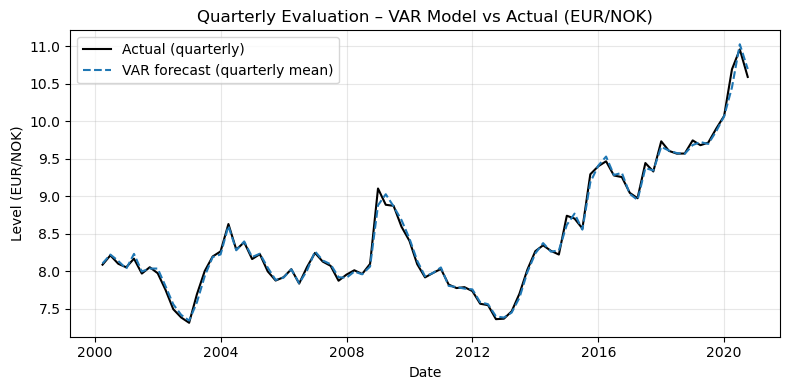

In [20]:
# ----------------------------
# 9) Quarterly evaluation (aggregate monthly to quarterly)
# ----------------------------

# Aggregate both actual and predicted monthly EUR/NOK to quarterly means
actual_quarterly = actual.resample('Q').mean()
predicted_quarterly = predicted.resample('Q').mean()

# Align indices and drop missing quarters
comparison_q = pd.concat([actual_quarterly, predicted_quarterly], axis=1)
comparison_q.columns = ["actual", "predicted"]
comparison_q = comparison_q.dropna()

# Extract aligned series
actual_q = comparison_q["actual"]
predicted_q = comparison_q["predicted"]

# Compute evaluation metrics on quarterly data
rmse_q = np.sqrt(mean_squared_error(actual_q, predicted_q))
mae_q = mean_absolute_error(actual_q, predicted_q)
directional_accuracy_q = np.mean(
    np.sign(np.diff(actual_q)) == np.sign(np.diff(predicted_q))
) * 100

print("\n=== Quarterly Evaluation (Aggregated from Monthly VAR) ===")
print(f"RMSE (quarterly): {rmse_q:.4f}")
print(f"MAE (quarterly): {mae_q:.4f}")
print(f"Directional accuracy (quarterly): {directional_accuracy_q:.1f}%")

# Plot quarterly actual vs predicted
plt.figure(figsize=(8,4))
plt.plot(actual_q.index, actual_q, label="Actual (quarterly)", color="black")
plt.plot(predicted_q.index, predicted_q, label="VAR forecast (quarterly mean)",
         color="tab:blue", linestyle="--")
plt.title("Quarterly Evaluation – VAR Model vs Actual (EUR/NOK)")
plt.ylabel("Level (EUR/NOK)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("VAR_Quarterly_Evaluation.png", dpi=300, bbox_inches="tight")
plt.show()
